# Calibarate EZmock parameters

Run this notebook in `cosmodesi` environment on NERSC.

Require: EZmock, `src/prep_ref.py`, `conf/`, displacement files prepared, `out/` which is soft linked to a dir in $SCRATCH.

In [1]:
import os
import numpy as np
from pathlib import Path
from EZmock import EZmock
import sys; sys.path.append("/global/homes/s/siyizhao/lib/EZmock/example/fit") # path to EZmock
from pyclustering import pyclustering
sys.path.append('src')
from prep_ref import read_Abacus_mock, save_ref_clus

## Read Reference Mock

In [2]:
sim='Abacus_pngbase_c302_ph000'
# sim='AbacusSummit_base_c000_ph000'
fnl =100
redshift = 0.95
hod='_dv'
# hod=''

### save reference clustering measurements
clustering_dir = str((Path().resolve() / 'clustering').resolve())
os.makedirs(clustering_dir, exist_ok=True)
pk_ref = f'{clustering_dir}/pkref.txt'
xi_ref = f'{clustering_dir}/xiref.txt'
bk_ref=f'{clustering_dir}/bkref.txt'

## first run of a reference catalog, please uncomment the following lines
# num, xref, yref, zref = read_Abacus_mock(sim=sim, z=redshift, hod=hod)
# save_ref_clus(xref, yref, zref, pk_ref, xi_ref, bk_ref)
# num

once read the reference, keep the number and omit the `read_Abacus_mock` and `save_ref_clus` to save time.

In [3]:
num = 18632755

## EZmock Setup

In [ ]:
# EZmock parameters
Omega_m0 = 0.3137721
Omega_nu = 0.00141976532
ncpu = 64
# Factor to be multiplied to the z-velocities for redshift-space distortion
rsd_fac = (1 + redshift) / (100 * np.sqrt(Omega_m0 * (1 + redshift)**3 + (1 - Omega_m0)))
# Output directory, should be large enough, we recommend to make a soft link to $SCRATCH
odir = 'out'

In [5]:
def setup_ez(Lbox=1000, Ngrid=256, seed=42):
    # Initialize EZmock instance
    ez = EZmock(Lbox=Lbox, Ngrid=Ngrid, seed=42, nthread=ncpu)
    ez.eval_growth_params(z_out=redshift, z_pk=1, Omega_m=Omega_m0, Omega_nu=Omega_nu)
    
    # Input linear power spectrum ###########
    # IDIR = '/pscratch/sd/s/siyizhao/EZmock/input/'
    # PLIN = 'plin_AbacusCosm000_z1.txt'
    # klin, plin = np.loadtxt(os.path.join(IDIR, PLIN), unpack=True)
    # ez.setup_linear_pk(klin, plin)
    # ez.create_dens_field_from_ic(fixamp=True)

    mydx=np.loadtxt(f'/pscratch/sd/s/siyizhao/2LPTdisp/dispx_{seed}.txt')
    mydy=np.loadtxt(f'/pscratch/sd/s/siyizhao/2LPTdisp/dispy_{seed}.txt')
    mydz=np.loadtxt(f'/pscratch/sd/s/siyizhao/2LPTdisp/dispz_{seed}.txt')
    ez.create_dens_field_from_disp(mydx,mydy,mydz, deepcopy=True)
    return ez

In [ ]:
Lbox = 2000
Ngrid = 512
seed = 43
ntracer = num
## to speed up the process during calibration, you can use smaller box and lower grid resolution first, and then go back to the right setting for final check
# Lbox = 1000
# Ngrid = 256
# seed = 42
# ntracer = num//8

ez = setup_ez(Lbox=Lbox, Ngrid=Ngrid, seed=seed)


### pyclustering

In [7]:
pyc = pyclustering(workdir=str(Path().resolve()),
    pk_exe='/global/homes/s/siyizhao/lib/powspec/POWSPEC',
    xi_exe='/global/homes/s/siyizhao/lib/FCFC/FCFC_2PT_BOX',
    bk_exe='/global/homes/s/siyizhao/lib/bispec_box/bispec',
    pk_ref=pk_ref,
    xi_ref=xi_ref,
    bk_ref=bk_ref,
    nthread=ncpu, verbose=False)

### run and plot EZmock

In [8]:
def run_and_plot_EZmock(ez, pyc, params):
    """
    Run EZmock with the given parameters and plot the clustering statistics.
    
    Parameters:
    ez (EZmock): The EZmock instance.
    pyc (pyclustering): The pyclustering instance.
    params (dict): List of EZmock parameters to be run.
    """
    fnames = []
    for param in params:
        rho_c, rho_exp, pdf_base, sigma_v = param
        fname = f'{odir}/EZmock_L{Lbox:g}_N{Ngrid:d}_fnl{fnl:g}_c{rho_c:g}_e{rho_exp:g}_b{pdf_base:g}_v{sigma_v:g}.dat'

        if not os.path.exists(fname):
            print(f'Running EZmock with parameters: {param}')
            # Run EZmock
            ez.populate_tracer_to_file(rho_c, rho_exp, pdf_base, sigma_v, ntracer, fname, rsd_fac=rsd_fac)
            # ez.populate_tracer_to_file(rho_c, rho_exp, pdf_base, sigma_v, ntracer, fname, att_part=True, rsd_fac=rsd_fac)
            # ez.populate_tracer(rho_c, rho_exp, pdf_base, sigma_v, ntracer, rsd_fac=rsd_fac)

        fnames.append(fname)
            
        # Measure clustering statistics
        pyc.run(fname, Lbox)

    # Plot clustering statistics
    pyc.plot(fnames)

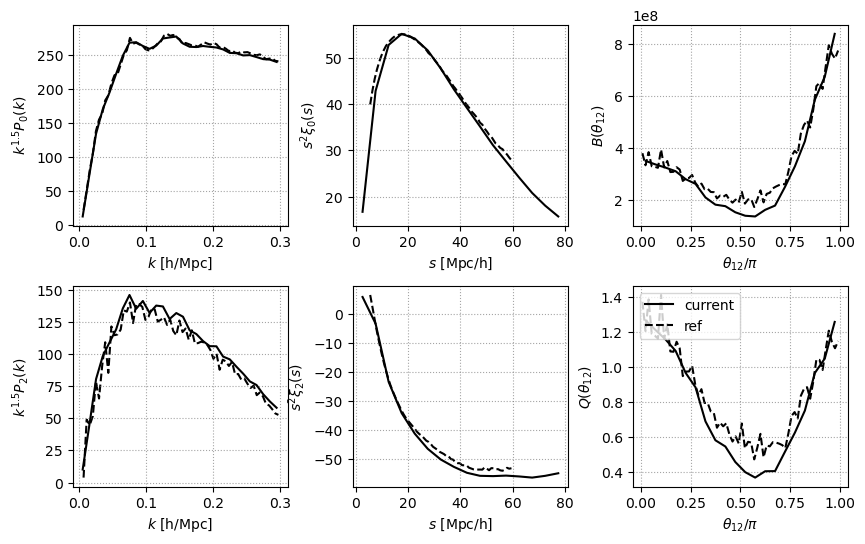

In [ ]:
params = [
  # [1.1, 1.45, 0.055, 355],
  # [0.85, 5, 0.35, 450],
  # [1.1, 1.45, 0.055, 150],
  # [0.85, 5, 0.35, 150], #
  # [0.85, 4, 0.35, 150],
  # [0.85, 1, 0.35, 150],
  # [0.85, 3, 0.35, 150],
  # [0.85, 3, 0.35, 100],
  # [0.8, 3, 0.35, 100],
  # [0.8, 3, 0.35, 0],
  # [0.8, 3, 0.4, 0],
  # [0.8, 2.5, 0.4, 0],
  # [0.8, 2.5, 0.42, 50],
  # [0.8, 2, 0.42, 200],
  # [0.8, 2, 0.45, 200],
  # [1, 2, 0.45, 200],
  # [1, 1.8, 0.45, 200],
  # [1, 1.5, 0.45, 200],
  # [1, 1.2, 0.45, 200],
  # [1, 1.2, 0.45, 150],
  # [1, 1.2, 0.48, 150],
  # [0.9, 1.2, 0.48, 150],
  # [0.9, 1.4, 0.48, 150],
  # [0.9, 1.4, 0.48, 140],
  # [0.9, 1.4, 0.49, 140],
  # [0.9, 1.4, 0.49, 160],
  # [0.9, 1.3, 0.49, 160],
  # [0.9, 1.3, 0.5, 160],
  [0.9, 1.3, 0.51, 160],
]

run_and_plot_EZmock(ez, pyc, params)